<a href="https://colab.research.google.com/github/DaveLoay/AP_Tarea_2/blob/main/AP_T2_EX2_PT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.-Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b045f949-c963-d8d3-081f-ddfcab1d368d)


In [3]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

In [4]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/face'
filename = 'UTKFace.tar.gz'
data_dir = '../data/face/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)): 
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    x *= 255
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    display_grid(x, titles, rows, cols, figsize)

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

# 2.- Datos
# Descarga de UTKFaces 

In [5]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2022-11-13 20:55:45--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/face/UTKFace.tar.gz’

../data/face/UTKFac 100%[===================>] 101.69M  1.95MB/s    in 45s     

2022-11-13 20:56:32 (2.27 MB/s) - ‘../data/face/UTKFace.tar.gz’ saved [106634631/106634631]



In [6]:
images = []
age = []
images_path_names = []

for img in os.listdir(data_dir):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  images.append(np.array(img))
  age.append(np.array(ages))
  image_path = os.path.join(base_dir, img)
  images_path_names.append(image_path)

age = np.array(age,dtype=np.int64)
images = np.array(images)
images_path_names = np.array(images_path_names)

In [7]:
age.shape

(23708,)

#Separando el DataSet en $80 \%$ entrenamiento $20 \%$ prueba y creando dataframes  

In [8]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test, ages_train, ages_test =  train_test_split(images, age, test_size = 0.2, random_state = 0 )

In [9]:
# Training DataSet
imgs_train = pd.Series(imgs_train, name = 'Image')
ages_train = pd.Series(ages_train, name = 'Age')
df_train = pd.concat([imgs_train,ages_train],axis = 1)
print(df_train.shape)
df_train.head()

(18966, 2)


,Image,Age
0,37_0_0_20170105172649108.jpg.chip.jpg,37
1,29_0_0_20170116192103987.jpg.chip.jpg,29
2,54_1_1_20170120223626558.jpg.chip.jpg,54
3,45_1_0_20170115231034803.jpg.chip.jpg,45
4,23_1_3_20170119164539192.jpg.chip.jpg,23


In [10]:
# Test DataSet
imgs_test = pd.Series(imgs_test, name = 'Image')
ages_test = pd.Series(ages_test, name = 'Age')
df_test = pd.concat([imgs_test,ages_test],axis = 1)
print(df_test.shape)
df_test.head()

(4742, 2)


,Image,Age
0,29_1_2_20170116192021943.jpg.chip.jpg,29
1,35_0_1_20170113142101291.jpg.chip.jpg,35
2,35_0_1_20170116022038426.jpg.chip.jpg,35
3,28_1_1_20170116021944520.jpg.chip.jpg,28
4,36_0_3_20170119180245724.jpg.chip.jpg,36


In [11]:
images = pd.Series(images, name = 'Image')
ages = pd.Series(age, name = 'Age')

df = pd.concat([images,ages],axis = 1)
df.head()

,Image,Age
0,58_1_0_20170120224803945.jpg.chip.jpg,58
1,45_1_0_20170117152126596.jpg.chip.jpg,45
2,26_1_1_20170116234835737.jpg.chip.jpg,26
3,7_1_0_20170109201718572.jpg.chip.jpg,7
4,9_1_0_20170109204754719.jpg.chip.jpg,9


# Creando archivos ''csv'' para cada conjunto de datos

In [13]:
# Creando Archivos .csv de los dataframes
from pathlib import Path  
filepath = Path(os.path.join(base_dir,'faces.csv'))  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

filepath_train = Path(os.path.join(base_dir,'faces_train.csv'))  
filepath_train.parent.mkdir(parents=True, exist_ok=True)
df_train.to_csv(filepath_train)

filepath_test = Path(os.path.join(base_dir,'faces_test.csv'))  
filepath_test.parent.mkdir(parents=True, exist_ok=True)
df_test.to_csv(filepath_test)


#Creando el Custom DataSet

In [14]:
from torch.utils.data.distributed import Dataset
from torchvision.io import read_image

class loayDS(Dataset):

  def __init__(self, csvfile, img_dir, transform):
    df = pd.read_csv(os.path.join(img_dir, csvfile))
    df_l = df['Image'].tolist()
    self.img_labels = []
    self.img_dir = []
    self.transform = transform
    for img in df_l:
      name = os.path.join(img_dir, img)
      self.img_labels.append(img.split("_")[0])
      self.img_dir.append(name)

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, index):
    img_path = self.img_dir[index]
    image = Image.open(img_path)
    image = self.transform(image)
    label = np.array(self.img_labels[index], np.int64)
    
    return image, label

#Exploración

Feature batch shape: torch.Size([32, 3, 64, 64]) dtypetorch.float32
Labels batch shape: torch.Size([32]) dtypetorch.int64


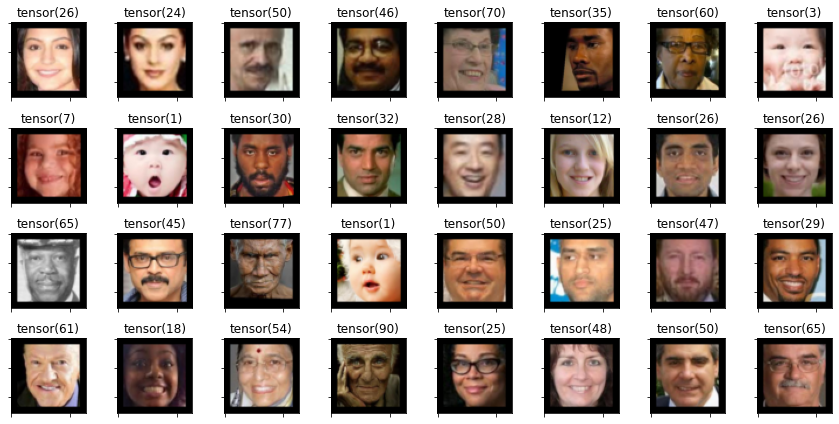

In [16]:
transform = transforms.Compose([
    transforms.CenterCrop(240),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    ])

csvfile = "/data/face/faces.csv"
csv_train = "/data/face/faces_train.csv"
csv_test = "/data/face/faces_test.csv"


loayds = loayDS(csvfile, data_dir, transform)
train_ds = loayDS(csv_train,data_dir,transform)
test_ds = loayDS(csv_test,data_dir,transform)

loay_dataloader = DataLoader(loayds, batch_size = BATCH_SIZE, shuffle = True)
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape} dtype{train_features.dtype}")
print(f"Labels batch shape: {train_labels.shape} dtype{train_labels.dtype}")
# train_labels = [f'{l.item()} = Sana' if l else f'{l.item()} = No Sana' for l in train_labels]
display_batch(train_features, train_labels, ROWS, COLS)

# 3.- Modelo

In [17]:
class ConvNext(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvNext, self).__init__()
        # out_channels1, out_channels2 = out_channels
        self.cnn_block = nn.Sequential(
            
            # Depthwise convolution
            nn.Conv2d(in_channels=3, 
                      out_channels=3, 
                      kernel_size=7, padding=3, 
                      groups = 3),
            # Layer Normalization
            nn.LayerNorm([3,64,64]),
            
            
            # Pointwise Convolution #1
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1),
            
            # GELU Activation Function
            nn.GELU(),

            # Pointwise Convolution #2
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1),


        )

    def forward(self, x):
        x1 = self.cnn_block(x)
        x = x1 + x
        return x


In [18]:
class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 3 * 32 * 32
        
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        self.cnn = nn.Sequential(
            # [N, 3, 64, 64] => [N, 3, 64, 64]
            ConvNext (in_channels=3, out_channels=(3,3)),
            
            # [N, 3, 64, 64] => [N, 3, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # [N, 3, 32, 32] => [N, 3x32x32]
        self.flatten = nn.Flatten()

        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 117)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = self.flatten(x)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 64, 64] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        y_prob = torch.sigmoid(y_lgts)
        return y_prob

In [19]:
# model = ConvNext(3,3)
model = MicroResNet()
summary(model, (3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─ConvNext: 2-1                     [-1, 3, 64, 64]           --
|    |    └─Sequential: 3-1              [-1, 3, 64, 64]           24,750
|    └─MaxPool2d: 2-2                    [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 117]                 359,541
Total params: 384,291
Trainable params: 384,291
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.05
Forward/backward pass size (MB): 0.38
Params size (MB): 1.47
Estimated Total Size (MB): 1.89

# Prueba de la Arquitectura

Ciclo de entrenamiento

In [20]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(y.shape)

torch.Size([1, 117])


# Funciones de entrenamiento y validación

In [21]:
def train_epoch(dl, model, opt):
    model.train()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # por cada lote
    for x, y_true in dl:
        
        x = x.to(device)
        y_true = y_true.to(device)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
                
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    model.eval()
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for x, y_true in take(dl, num_batches):
        
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts,1)
            
            # computamos las clases
            y_pred = torch.argmax(y_prob,1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=15e-3, epochs=15,
          trn_batches=None):
    
    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist



 # Ciclo de entrenamiento

In [22]:
train(model, train_dataloader)

E00 loss=387.15 acc=11.77
E01 loss=370.45 acc=13.06
E02 loss=363.82 acc=14.31
E03 loss=354.02 acc=13.52
E04 loss=340.69 acc=16.06
E05 loss=334.08 acc=16.32
E06 loss=322.22 acc=18.72
E07 loss=311.84 acc=20.58
E08 loss=304.19 acc=21.41
E09 loss=297.18 acc=21.56
E10 loss=276.64 acc=26.88
E11 loss=265.34 acc=28.85
E12 loss=255.46 acc=31.28
E13 loss=241.61 acc=35.25
E14 loss=239.62 acc=35.36


([387.1538090665666,
  370.4484254071524,
  363.8212509943301,
  354.02050653557353,
  340.69441378016097,
  334.0772267336789,
  322.21771167060376,
  311.8368926377964,
  304.1911745553877,
  297.17612556020083,
  276.6422280573724,
  265.33558724501484,
  255.46358331258944,
  241.61115050516884,
  239.62395146966583],
 [11.769412081016457,
  13.060037560547382,
  14.307067300778819,
  13.522344013490725,
  16.05616664202981,
  16.322531811201955,
  18.71790203939602,
  20.581021002834603,
  21.410298176599795,
  21.56312279717315,
  26.882761000682294,
  28.84648551325774,
  31.279702592659962,
  35.245477540094974,
  35.361413459150626])

# GUardando modelo

In [23]:
torch.save(model,'model_2.pth')

# Evaluación del modelo

In [27]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in test_dataloader:
        # hacemos inferencia para obtener los logits
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = x.to(device)
        y_true = y_true.to(device)
        # movemos a dispositivo
        model.to(device)
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')



Exactitud = 11.03


In [29]:
with torch.no_grad(): 
    for x, y_true in take(test_dataloader, 1):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = x.to(device)
        y_true = y_true.to(device)
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
# display_grid(x, titles, 4, 8)
display_batch(x, titles, ROWS, COLS)



TypeError: ignored

# Discusion

En esta sección se discutirán los resultados referentes al modelo con el bloque ConvNext.

El problema de estimación de edad con base en el DataSet de UTKFace, se abordó como un problema de clasificación multiclase, es decir, cada edad se tomo como una clase distinta, terminando con 117 clases (hay personas desde 0 años hasta 116 años en el dataset). Se modificó el ciclo de entrnamiento, en donde se cambió la función de perdida por una función de entropía cruzada.

De tal forma que los resultados del entranamiento entregan una exactitud muy cercana al $\% 50$, sin embargo, con el conjunto de evaluación se llegó a una exactitud del $\% 11$. Si se observa la tendencia de la exactitud en el entrenamiento, se puede notar la tendencia incremental conforme pasan las épocas, por lo que se presupone que, si se aumentaran los ciclos de entrenamiento, también se llegarían a niveles más competitivos en la estimación de edad.

Adicionalmente, se realizó un histograma de la distribución de edades y se notó que es un DataSet bastante desbalanciado, contando con muchas muestras en edades bajas y muy pocas a medida que aumenta la edad. Lo cual infuyo en el ajuste del modelo ante los datos.